This notebook covers data extraction for the dataset used to train the CELFANN model in the research paper "A hybrid stock trading framework integrating technical analysis with machine learning" (Dash & Dash, 2016)

This notebook extracts financial data used to train our implementation of the CEFLANN model from "A hybrid stock trading framework integrating technical analysis with machine learning" (Dash & Dash, 2016)

In [42]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
plt.style.use('seaborn-v0_8-darkgrid')

In [43]:
start_date = '2020-01-01'
end_date = '2023-12-31'  
tickers = {
    'NVIDIA': 'NVDA',
    'Taiwan Semiconductors': 'TSM',
    'Invesco QQQ': 'QQQ'
}

In [44]:
data = {}
for name, ticker in tickers.items():
    print(f"Downloading data for {name} ({ticker})...")
    data[name] = yf.download(ticker, start=start_date, end=end_date)
    print(f"Downloaded {len(data[name])} days of data for {name}.")
    print(f"Displaying data for {name}:")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Downloaded 1006 days of data for NVIDIA.
Displaying data for NVIDIA:
Downloaded 1006 days of data for Taiwan Semiconductors.
Displaying data for Taiwan Semiconductors:
Downloaded 1006 days of data for Invesco QQQ.
Displaying data for Invesco QQQ:



Price Correlation Matrix:
                         NVIDIA  Taiwan Semiconductors  Invesco QQQ
NVIDIA                 1.000000               0.440769     0.797496
Taiwan Semiconductors  0.440769               1.000000     0.840628
Invesco QQQ            0.797496               0.840628     1.000000


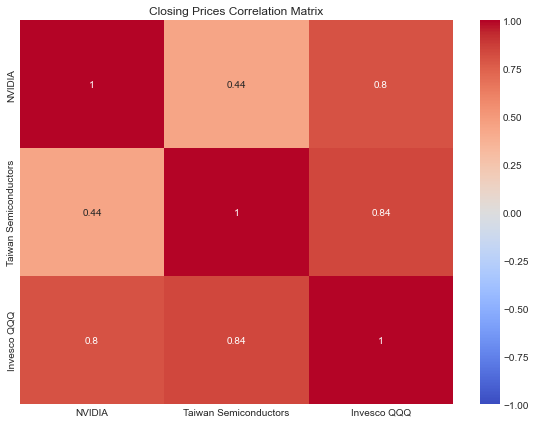

In [45]:
# Extract closing prices for correlation analysis
close_prices = pd.DataFrame()
for name, ticker_data in data.items():
    close_prices[name] = ticker_data['Close']

# Calculate correlation matrix
correlation = close_prices.corr()
print("\nPrice Correlation Matrix:")
print(correlation)

# Visualize correlation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Closing Prices Correlation Matrix')
plt.tight_layout()
plt.show()

In [92]:
for k,v in data.items():
    print(type(k))
    print(type(v))

ValueError: too many values to unpack (expected 2)

In [80]:
for name, ticker_data in data.items():
    print (data[name]['Close'].head())
    print (data[name]['Close'].tail())

dict_items([('NVIDIA', Price           Close       High        Low       Open     Volume
Ticker           NVDA       NVDA       NVDA       NVDA       NVDA
Date                                                             
2020-01-02   5.972710   5.972710   5.893293   5.943831  237536000
2020-01-03   5.877112   5.920928   5.828067   5.852963  205384000
2020-01-06   5.901759   5.906987   5.757613   5.783754  262636000
2020-01-07   5.973208   6.019016   5.885078   5.930139  314856000
2020-01-08   5.984412   6.025739   5.928895   5.968977  277108000
...               ...        ...        ...        ...        ...
2023-12-22  48.816162  49.369003  48.453262  49.181057  252507000
2023-12-26  49.265030  49.585938  48.946120  48.954117  244200000
2023-12-27  49.402992  49.665918  49.071086  49.496967  233648000
2023-12-28  49.507965  49.869862  49.397996  49.628933  246587000
2023-12-29  49.507965  49.982833  48.737184  49.798883  389293000

[1006 rows x 5 columns]), ('Taiwan Semiconductors', 

In [69]:
# Function calculates six technical indicators used by the CEFLANN model
def calculate_technical_indicators(df):

    data = df.copy()
    
    # 1: Simple Moving Average (MA15)
    data['MA15'] = data['Close'].rolling(window=15).mean()
    
    # 2: MACD (12, 26)
    data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD26'] = data['EMA12'] - data['EMA26']
    
    # 3: Stochastic Oscillator K14
    n = 14
    data['L14'] = data['Low'].rolling(window=n).min()
    data['H14'] = data['High'].rolling(window=n).max()
    print(f"\nClosing prices for {data}")
    print(data['Close'])
    print(data['L14'])
    print(data['H14'])
    #data['K14'] = 100 * ((data['Close'] - data['L14']) / (data['H14'] - data['L14']))
    
    # 4: Stochastic Oscillator D3
    #data['D3'] = data['K14'].rolling(window=3).mean()
    
    # 5: Relative Strength Index (14)
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI14'] = 100 - (100 / (1 + rs))
    
    # 6: Larry Williams R% (WR14)
    #data['WR14'] = -100 * ((data['H14'] - data['Close']) / (data['H14'] - data['L14']))
    
    # Clean up columns
    data = data.drop(['L14', 'H14', 'EMA12', 'EMA26'], axis=1)
    
    return data

In [70]:
# Calculate technical indicators for all tickers
tech_data = data.copy()
for name in tickers.keys():
    tech_data[name] = calculate_technical_indicators(tech_data[name])
    tech_data[name].tail().round(2)

print("The length of the dictionary is {}".format(len(tech_data)))
'''for name, ticker_data in tech_data.items():
    print (tech_data[name].head())
    print (tech_data[name].tail())'''

Ticker           NVDA
Date                 
2020-01-02   5.972710
2020-01-03   5.877112
2020-01-06   5.901759
2020-01-07   5.973208
2020-01-08   5.984412
...               ...
2023-12-22  48.816162
2023-12-26  49.265030
2023-12-27  49.402992
2023-12-28  49.507965
2023-12-29  49.507965

[1006 rows x 1 columns]
Date
2020-01-02          NaN
2020-01-03          NaN
2020-01-06          NaN
2020-01-07          NaN
2020-01-08          NaN
                ...    
2023-12-22    45.258168
2023-12-26    45.399127
2023-12-27    45.591075
2023-12-28    45.817014
2023-12-29    45.817014
Name: L14, Length: 1006, dtype: float64
Date
2020-01-02          NaN
2020-01-03          NaN
2020-01-06          NaN
2020-01-07          NaN
2020-01-08          NaN
                ...    
2023-12-22    50.418703
2023-12-26    50.418703
2023-12-27    50.418703
2023-12-28    50.418703
2023-12-29    50.418703
Name: H14, Length: 1006, dtype: float64
Ticker             TSM
Date                  
2020-01-02   54.504322
20

'for name, ticker_data in tech_data.items():\n    print (tech_data[name].head())\n    print (tech_data[name].tail())'

In [12]:
# Normalize indicators using Min-Max normalization
# The function returns a dataframe of normalized indicator values, along with the statistical distribution of each indicator.
def normalize_indicators(df):

    indicators = ['MA15', 'MACD26', 'K14', 'D3', 'RSI14', 'WR14']
    
    normalized_df = df[indicators].copy()
    stats = {}
    for indicator in indicators:
        stats[indicator] = {
            'min': df[indicator].min(),
            'max': df[indicator].max(),
            'mean': df[indicator].mean(),
            'std': df[indicator].std()
        }
        
       
        normalized_df[indicator] = (df[indicator] - stats[indicator]['min']) / \
                                  (stats[indicator]['max'] - stats[indicator]['min'])
    
    
    normalized_df['Close'] = df['Close']
    
    return normalized_df, stats

In [13]:
# Prepare data for CEFLANN model training
def prepare_data(normalized_df, window_size=15):
    
    df = normalized_df.copy()
    
    # Add trend column (1 for uptrend, 0 for downtrend)
    # Using original dataframe to get Close and MA15 values
    original_df = data[name].copy()
    df['trend'] = 0
    
    # Uptrend condition: Close price > MA15 and MA15 is rising for the last 5 days
    ma_rising = original_df['MA15'].diff(5) > 0
    close_above_ma = original_df['Close'] > original_df['MA15']
    df.loc[ma_rising & close_above_ma, 'trend'] = 1
    
    # Downtrend condition: Close price < MA15 and MA15 is falling for the last 5 days
    ma_falling = original_df['MA15'].diff(5) < 0
    close_below_ma = original_df['Close'] < original_df['MA15']
    df.loc[ma_falling & close_below_ma, 'trend'] = 0
    
    # Generate trading signals in range 0-1 based on trend
    df['trading_signal'] = 0.5  # default for no clear trend
    
    
    for i in range(len(df) - 2):
        # If the price is trending up:
        if df['trend'].iloc[i] == 1:
            # Get min and max close prices for the next 3 days
            prices = original_df['Close'].iloc[i:i+3].values
            min_cp = min(prices)
            max_cp = max(prices)
            current_cp = original_df['Close'].iloc[i]
            
            # Calculate trading signal for uptrend
            if max_cp > min_cp:  
                df['trading_signal'].iloc[i] = ((current_cp - min_cp) / (max_cp - min_cp)) * 0.5 + 0.5
        
        # If the price is trending down:
        elif df['trend'].iloc[i] == 0:
            # Get min and max close prices for the next 3 days
            prices = original_df['Close'].iloc[i:i+3].values
            min_cp = min(prices)
            max_cp = max(prices)
            current_cp = original_df['Close'].iloc[i]
            
            # Calculate trading signal for downtrend
            if max_cp > min_cp:  # Avoid division by zero
                df['trading_signal'].iloc[i] = ((current_cp - min_cp) / (max_cp - min_cp)) * 0.5
    
    # Drop NaN values that might have occurred during calculations
    df.dropna(inplace=True)
    
    # Features (X) and target (y)
    X = df[['MA15', 'MACD26', 'K14', 'D3', 'RSI14', 'WR14']].values
    y = df['trading_signal'].values
    
    return df, X, y

In [ ]:
# Split the data into training and testing sets
def split_data(X, y, train_ratio=0.8):
    """Split the data into training and testing sets"""
    train_size = int(len(X) * train_ratio)
    
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    
    return X_train, y_train, X_test, y_test

# Split the data for both indices
train_test_data = {}

for name in indices.keys():
    X_train, y_train, X_test, y_test = split_data(features[name], targets[name])
    train_test_data[name] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    }
    print(f"Split {name} data into {len(X_train)} training samples and {len(X_test)} testing samples")

In [ ]:
# Normalize the technical indicators for all stocks
normalized_data = {}
indicator_stats = {}

for name in tickers.keys():
    normalized_data[name], indicator_stats[name] = normalize_indicators(data[name])
    print(f"Normalized technical indicators for {name}")

In [ ]:
# Display summary statistics for NVDA indicators
indicator_summary_sp500 = pd.DataFrame(indicator_stats['NVIDIA']).T.round(2)
indicator_summary_sp500
normalized_data['NVIDIA'].tail()

In [ ]:
# Visualize the trend analysis using MA15 for NVIDIA
plt.figure(figsize=(14, 7))
plt.plot(data['NVIDIA'].index, data['NVIDIA']['Close'], label='Close Price', color='blue')
plt.plot(data['NVIDIA'].index, data['NVIDIA']['MA15'], label='MA15', color='red', linestyle='--')

# Mark uptrend and downtrend regions
uptrend = data['NVIDIA'][data['NVIDIA']['Close'] > data['NVIDIA']['MA15']]
downtrend = data['NVIDIA'][data['NVIDIA']['Close'] < data['NVIDIA']['MA15']]

plt.scatter(uptrend.index, uptrend['Close'], color='green', alpha=0.5, s=10, label='Uptrend')
plt.scatter(downtrend.index, downtrend['Close'], color='red', alpha=0.5, s=10, label='Downtrend')

plt.title('NVIDIA Trend Analysis (2020-2023)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Preparing the data for CEFLANN model for all indices
ceflann_data = {}
features = {}
targets = {}

for name in indices.keys():
    ceflann_data[name], features[name], targets[name] = prepare_data(normalized_data[name])
    print(f"Prepared {len(features[name])} samples for CEFLANN model training for {name}")

In [ ]:
# Display a sample of the prepared data for NVIDIA
ceflann_data['NVDA'].tail()